# Kaggle Flight Delays

- Url: https://www.kaggle.com/competitions/flight-delays-spring-2018/
- Alunos: rjhxa@cesar.school e gsg@cesar.school

In [123]:
# General Imports
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostClassifier

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Functions

In [2]:
def get_origin_csv():
    x = pd.read_csv('raw_data/flight_delays_train.csv')
    y = pd.read_csv('raw_data/flight_delays_test.csv')

    return x, y

In [4]:
def transform_df(df):
    df['Month'] = df['Month'].str[2:].astype('int')
    df['DayofMonth'] = df['DayofMonth'].str[2:].astype('int')
    df['DayOfWeek'] = df['DayOfWeek'].str[2:].astype('int')
    df['DepTime_hour'] = df['DepTime']//100
    df['DepTime_minute'] =  df['DepTime']%100

    return df

In [100]:
def prepare_df(train, test, cols):
    x_train = train.drop(cols, axis=1)
    cols.remove('dep_delayed_15min')
    x_test = test.drop(cols, axis=1)

    return x_train, x_test

In [156]:
def convert_period(hour):
    aux = ''
    if hour >= 6 and hour < 12:
        aux = 'morning'
    elif hour >= 12 and hour < 18:
        aux = 'afternoon'
    elif hour >= 18 and hour < 24:
        aux = 'night'
    else:
        aux = 'dawn'

    return aux

## Exploraty Data Analysis (EDA)

In [5]:
train, test = get_origin_csv()

In [6]:
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N


In [7]:
test

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258
...,...,...,...,...,...,...,...,...
99995,c-6,c-5,c-2,852,WN,CRP,HOU,187
99996,c-11,c-24,c-6,1446,UA,ORD,LAS,1515
99997,c-1,c-30,c-2,1509,OO,ORD,SGF,438
99998,c-1,c-5,c-5,804,DL,LGA,ATL,761


In [117]:
train.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'dep_delayed_15min',
       'UniqueCarrier_encoded', 'DepTime_hour', 'DepTime_minute', 'Route'],
      dtype='object')

In [118]:
test.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'UniqueCarrier_encoded', 'DepTime_hour',
       'DepTime_minute', 'Route'],
      dtype='object')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 non-null  object
 2   DayOfWeek      100000 non-null  object
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


In [10]:
train.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1341.523880,729.39716
std,476.378445,574.61686
min,1.000000,30.00000
25%,931.000000,317.00000
50%,1330.000000,575.00000
75%,1733.000000,957.00000
max,2534.000000,4962.00000


In [11]:
test.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1338.936600,723.13011
std,480.554102,563.22322
min,1.000000,31.00000
25%,928.000000,321.00000
50%,1329.000000,574.00000
75%,1733.000000,948.00000
max,2400.000000,4962.00000


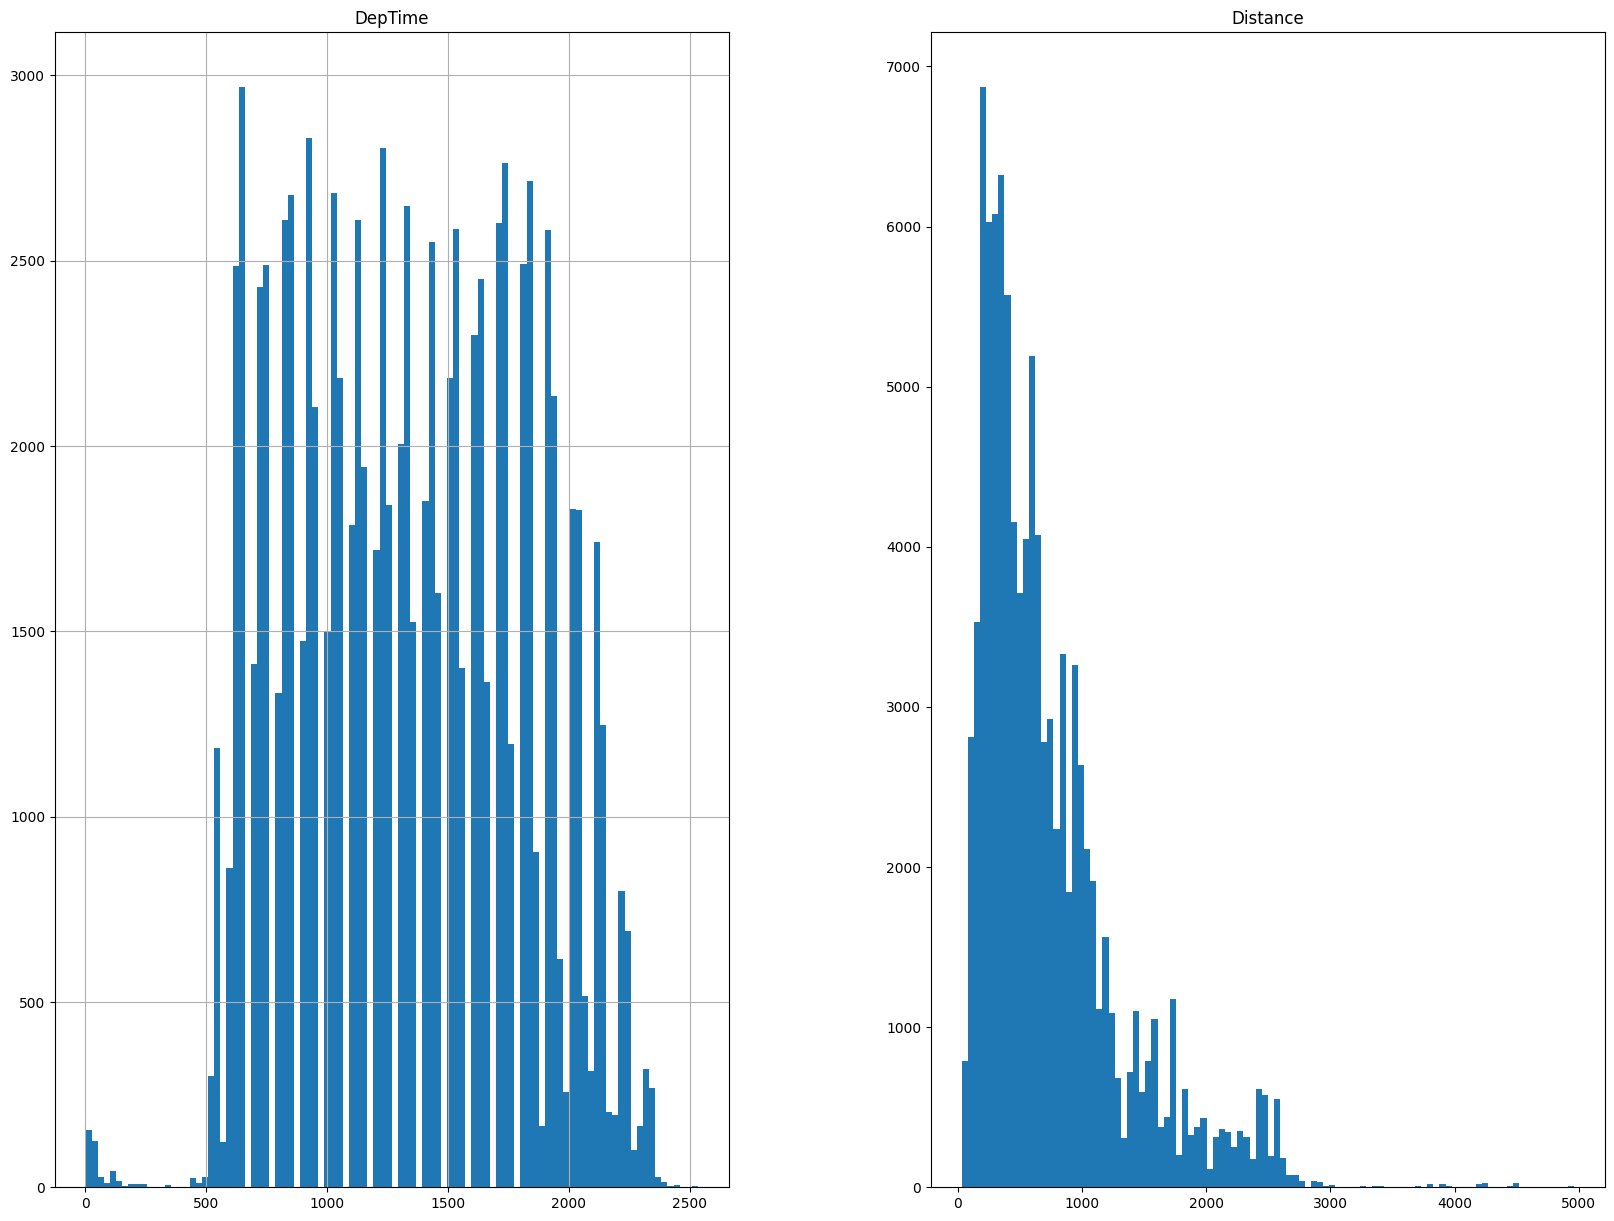

In [12]:
train.hist(bins=100, figsize=(20,15))
plt.grid()
plt.show()

## Data Processing

- Transforming columns to make better use of features and creating new ones to increase catboot performance

In [21]:
pd.set_option('future.no_silent_downcasting', True)

### Feature Engineering

In [22]:
train['dep_delayed_15min'] = train['dep_delayed_15min'].replace({'N': 0, 'Y': 1})
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,UniqueCarrier_encoded
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,0,1
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,0,19
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,0,21
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,0,16
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,1,20
...,...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,0,16
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,0,5
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,0,14
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,0,13


In [23]:
train = transform_df(train)
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,UniqueCarrier_encoded,DepTime_hour,DepTime_minute
0,8,21,7,1934,AA,ATL,DFW,732,0,1,19,34
1,4,20,3,1548,US,PIT,MCO,834,0,19,15,48
2,9,2,5,1422,XE,RDU,CLE,416,0,21,14,22
3,11,25,6,1015,OO,DEN,MEM,872,0,16,10,15
4,10,7,6,1828,WN,MDW,OMA,423,1,20,18,28
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5,4,3,1618,OO,SFO,RDD,199,0,16,16,18
99996,1,18,3,804,CO,EWR,DAB,884,0,5,8,4
99997,1,24,2,1901,NW,DTW,IAH,1076,0,14,19,1
99998,4,27,4,1515,MQ,DFW,GGG,140,0,13,15,15


In [24]:
test = transform_df(test)
test

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,UniqueCarrier_encoded,DepTime_hour,DepTime_minute
0,7,25,3,615,YV,MRY,PHX,598,22,6,15
1,4,17,2,739,WN,LAS,HOU,1235,20,7,39
2,12,2,7,651,MQ,GSP,ORD,577,13,6,51
3,3,25,7,1614,WN,BWI,MHT,377,20,16,14
4,6,6,3,1505,UA,ORD,STL,258,18,15,5
...,...,...,...,...,...,...,...,...,...,...,...
99995,6,5,2,852,WN,CRP,HOU,187,20,8,52
99996,11,24,6,1446,UA,ORD,LAS,1515,18,14,46
99997,1,30,2,1509,OO,ORD,SGF,438,16,15,9
99998,1,5,5,804,DL,LGA,ATL,761,7,8,4


In [26]:
train['Route'] =  train['Origin'] + "_" + train['Dest']
test['Route'] =  test['Origin'] + "_" + test['Dest']

In [144]:
train['Time_period'] = train['DepTime_hour'].apply(convert_period)
test['Time_period'] = test['DepTime_hour'].apply(convert_period)

In [145]:
train['Time_period'].value_counts()

Time_period
morning      38376
afternoon    37391
night        22111
dawn          2122
Name: count, dtype: int64

In [161]:
train['Route_Hour'] = train['Route'] + '_' + train['DepTime_hour'].astype('str')
test['Route_Hour'] = test['Route'] + '_' + test['DepTime_hour'].astype('str')

In [170]:
train['Carrier_Origin'] = train['UniqueCarrier'] + "_" + train['Origin']
train['Carrier_Dest'] = train['UniqueCarrier'] + "_" + train['Dest']
train['Carrier_DepHour'] = train['UniqueCarrier'] + '_' + train['DepTime_hour'].astype('str')

test['Carrier_Origin'] = test['UniqueCarrier'] + "_" + test['Origin']
test['Carrier_Dest'] = test['UniqueCarrier'] + "_" + test['Dest']
test['Carrier_DepHour'] = test['UniqueCarrier'] + '_' + test['DepTime_hour'].astype('str')

In [171]:
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,UniqueCarrier_encoded,DepTime_hour,DepTime_minute,Route,Time_period,Route_Hour,Carrier_Origin,Carrier_Dest,Carrier_DepHour
0,8,21,7,1934,AA,ATL,DFW,732,0,1,19,34,ATL_DFW,night,ATL_DFW_19,AA_ATL,AA_DFW,AA_19
1,4,20,3,1548,US,PIT,MCO,834,0,19,15,48,PIT_MCO,afternoon,PIT_MCO_15,US_PIT,US_MCO,US_15
2,9,2,5,1422,XE,RDU,CLE,416,0,21,14,22,RDU_CLE,afternoon,RDU_CLE_14,XE_RDU,XE_CLE,XE_14
3,11,25,6,1015,OO,DEN,MEM,872,0,16,10,15,DEN_MEM,morning,DEN_MEM_10,OO_DEN,OO_MEM,OO_10
4,10,7,6,1828,WN,MDW,OMA,423,1,20,18,28,MDW_OMA,night,MDW_OMA_18,WN_MDW,WN_OMA,WN_18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5,4,3,1618,OO,SFO,RDD,199,0,16,16,18,SFO_RDD,afternoon,SFO_RDD_16,OO_SFO,OO_RDD,OO_16
99996,1,18,3,804,CO,EWR,DAB,884,0,5,8,4,EWR_DAB,morning,EWR_DAB_8,CO_EWR,CO_DAB,CO_8
99997,1,24,2,1901,NW,DTW,IAH,1076,0,14,19,1,DTW_IAH,night,DTW_IAH_19,NW_DTW,NW_IAH,NW_19
99998,4,27,4,1515,MQ,DFW,GGG,140,0,13,15,15,DFW_GGG,afternoon,DFW_GGG_15,MQ_DFW,MQ_GGG,MQ_15


In [172]:
test

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,UniqueCarrier_encoded,DepTime_hour,DepTime_minute,Route,Time_period,Route_Hour,Carrier_Origin,Carrier_Dest,Carrier_DepHour
0,7,25,3,615,YV,MRY,PHX,598,22,6,15,MRY_PHX,morning,MRY_PHX_6,YV_MRY,YV_PHX,YV_6
1,4,17,2,739,WN,LAS,HOU,1235,20,7,39,LAS_HOU,morning,LAS_HOU_7,WN_LAS,WN_HOU,WN_7
2,12,2,7,651,MQ,GSP,ORD,577,13,6,51,GSP_ORD,morning,GSP_ORD_6,MQ_GSP,MQ_ORD,MQ_6
3,3,25,7,1614,WN,BWI,MHT,377,20,16,14,BWI_MHT,afternoon,BWI_MHT_16,WN_BWI,WN_MHT,WN_16
4,6,6,3,1505,UA,ORD,STL,258,18,15,5,ORD_STL,afternoon,ORD_STL_15,UA_ORD,UA_STL,UA_15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,6,5,2,852,WN,CRP,HOU,187,20,8,52,CRP_HOU,morning,CRP_HOU_8,WN_CRP,WN_HOU,WN_8
99996,11,24,6,1446,UA,ORD,LAS,1515,18,14,46,ORD_LAS,afternoon,ORD_LAS_14,UA_ORD,UA_LAS,UA_14
99997,1,30,2,1509,OO,ORD,SGF,438,16,15,9,ORD_SGF,afternoon,ORD_SGF_15,OO_ORD,OO_SGF,OO_15
99998,1,5,5,804,DL,LGA,ATL,761,7,8,4,LGA_ATL,morning,LGA_ATL_8,DL_LGA,DL_ATL,DL_8


### Label Encoder

- I applied a Label Encoder to the 'Unique Carrier' column because it has a limited number of unique values. This encoding helps to normalize the column and make it suitable for the machine learning model.

In [173]:
combined_unique_carrier = pd.concat([train['UniqueCarrier'], test['UniqueCarrier']], axis=0)

label_encoder = LabelEncoder()

label_encoder.fit(combined_unique_carrier)

train['UniqueCarrier_encoded'] = label_encoder.transform(train['UniqueCarrier'])
test['UniqueCarrier_encoded'] = label_encoder.transform(test['UniqueCarrier'])

print(train[['UniqueCarrier', 'UniqueCarrier_encoded']].head())
print(test[['UniqueCarrier', 'UniqueCarrier_encoded']].head())

  UniqueCarrier  UniqueCarrier_encoded
0            AA                      1
1            US                     19
2            XE                     21
3            OO                     16
4            WN                     20
  UniqueCarrier  UniqueCarrier_encoded
0            YV                     22
1            WN                     20
2            MQ                     13
3            WN                     20
4            UA                     18


In [174]:
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,UniqueCarrier_encoded,DepTime_hour,DepTime_minute,Route,Time_period,Route_Hour,Carrier_Origin,Carrier_Dest,Carrier_DepHour
0,8,21,7,1934,AA,ATL,DFW,732,0,1,19,34,ATL_DFW,night,ATL_DFW_19,AA_ATL,AA_DFW,AA_19
1,4,20,3,1548,US,PIT,MCO,834,0,19,15,48,PIT_MCO,afternoon,PIT_MCO_15,US_PIT,US_MCO,US_15
2,9,2,5,1422,XE,RDU,CLE,416,0,21,14,22,RDU_CLE,afternoon,RDU_CLE_14,XE_RDU,XE_CLE,XE_14
3,11,25,6,1015,OO,DEN,MEM,872,0,16,10,15,DEN_MEM,morning,DEN_MEM_10,OO_DEN,OO_MEM,OO_10
4,10,7,6,1828,WN,MDW,OMA,423,1,20,18,28,MDW_OMA,night,MDW_OMA_18,WN_MDW,WN_OMA,WN_18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5,4,3,1618,OO,SFO,RDD,199,0,16,16,18,SFO_RDD,afternoon,SFO_RDD_16,OO_SFO,OO_RDD,OO_16
99996,1,18,3,804,CO,EWR,DAB,884,0,5,8,4,EWR_DAB,morning,EWR_DAB_8,CO_EWR,CO_DAB,CO_8
99997,1,24,2,1901,NW,DTW,IAH,1076,0,14,19,1,DTW_IAH,night,DTW_IAH_19,NW_DTW,NW_IAH,NW_19
99998,4,27,4,1515,MQ,DFW,GGG,140,0,13,15,15,DFW_GGG,afternoon,DFW_GGG_15,MQ_DFW,MQ_GGG,MQ_15


In [115]:
train['UniqueCarrier_encoded'].value_counts()

UniqueCarrier_encoded
20    15082
1      9418
7      8128
13     7443
16     7390
18     6876
19     6482
14     6403
21     5901
15     4594
5      4334
8      3930
10     3039
3      2222
22     2128
4      1838
12     1378
9      1006
6       966
11      762
17      446
2       234
Name: count, dtype: int64

In [14]:
test['UniqueCarrier'].value_counts()

UniqueCarrier
WN    15876
AA     8606
OO     7953
MQ     6981
US     6587
DL     6496
UA     6435
XE     5836
NW     5602
CO     4367
YV     3901
EV     3770
FL     3500
9E     3461
OH     3103
B6     2651
AS     2134
F9     1390
HA      722
AQ      629
Name: count, dtype: int64

### Some Plots After Processing

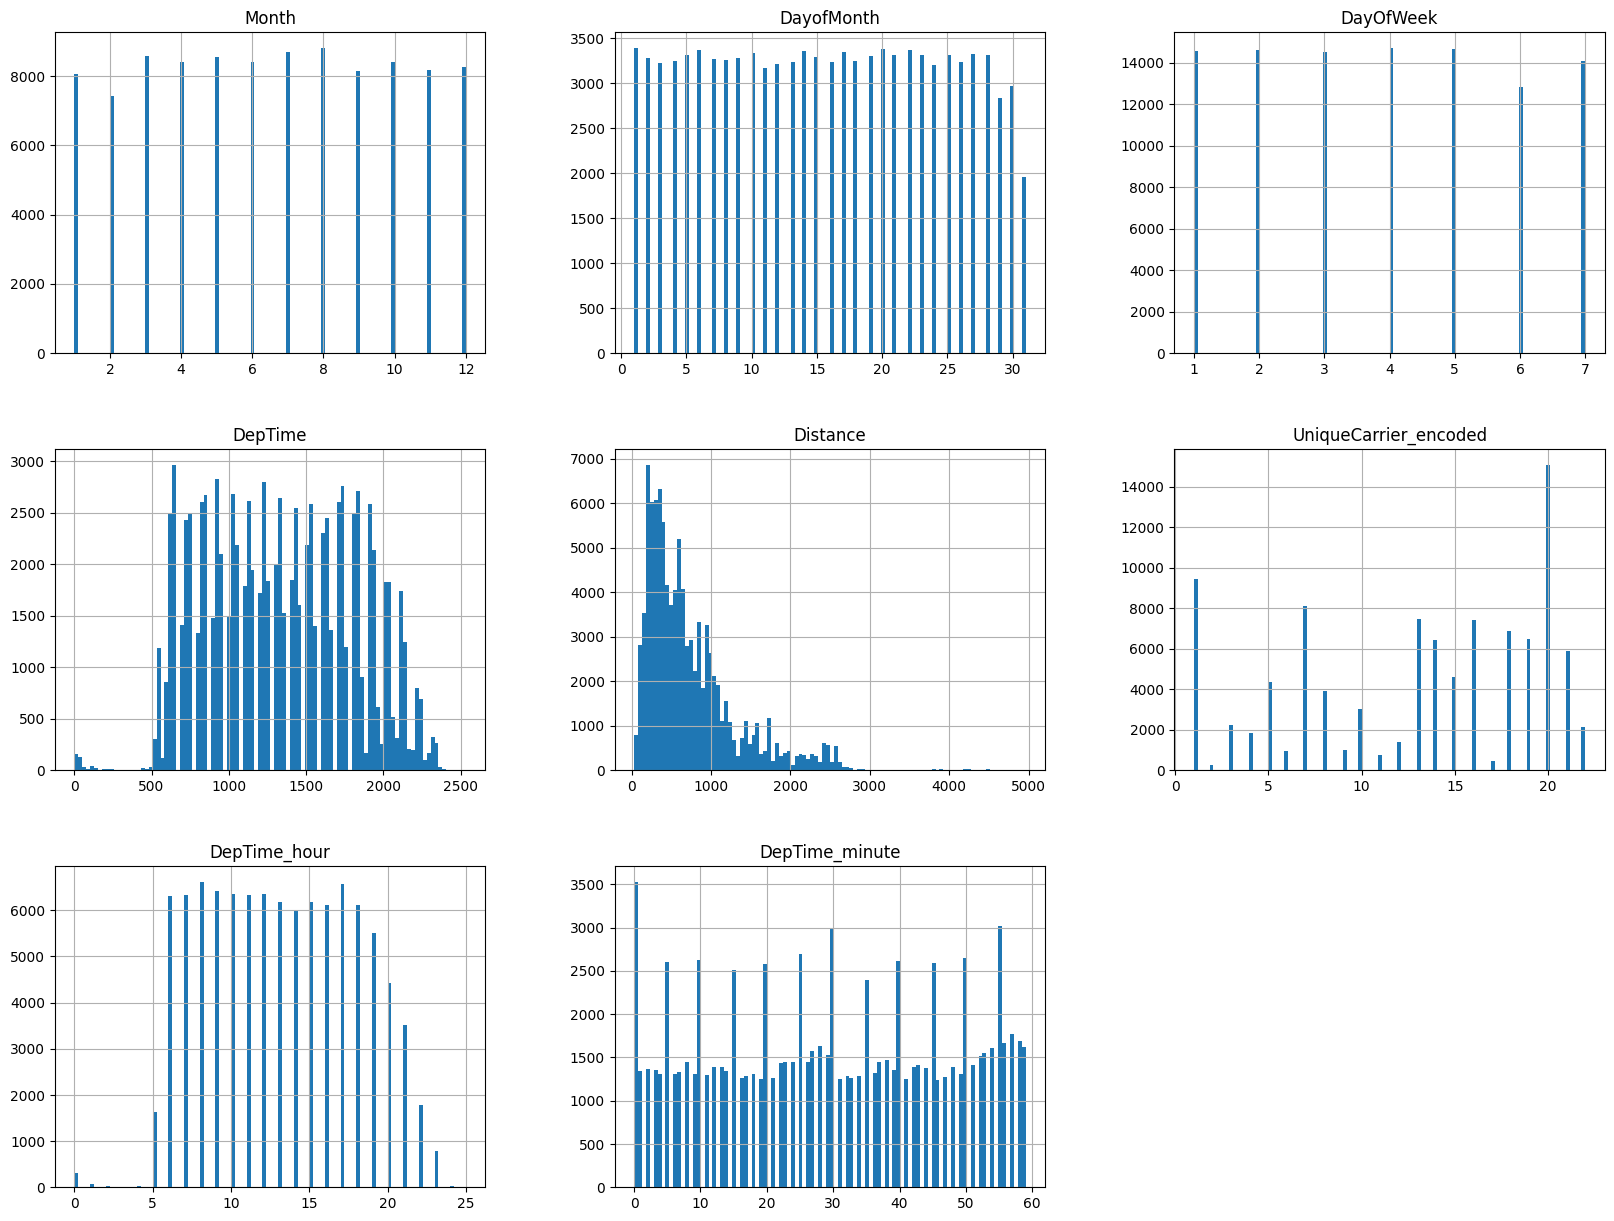

In [120]:
train.hist(bins=100, figsize=(20,15))
plt.grid()
plt.show()

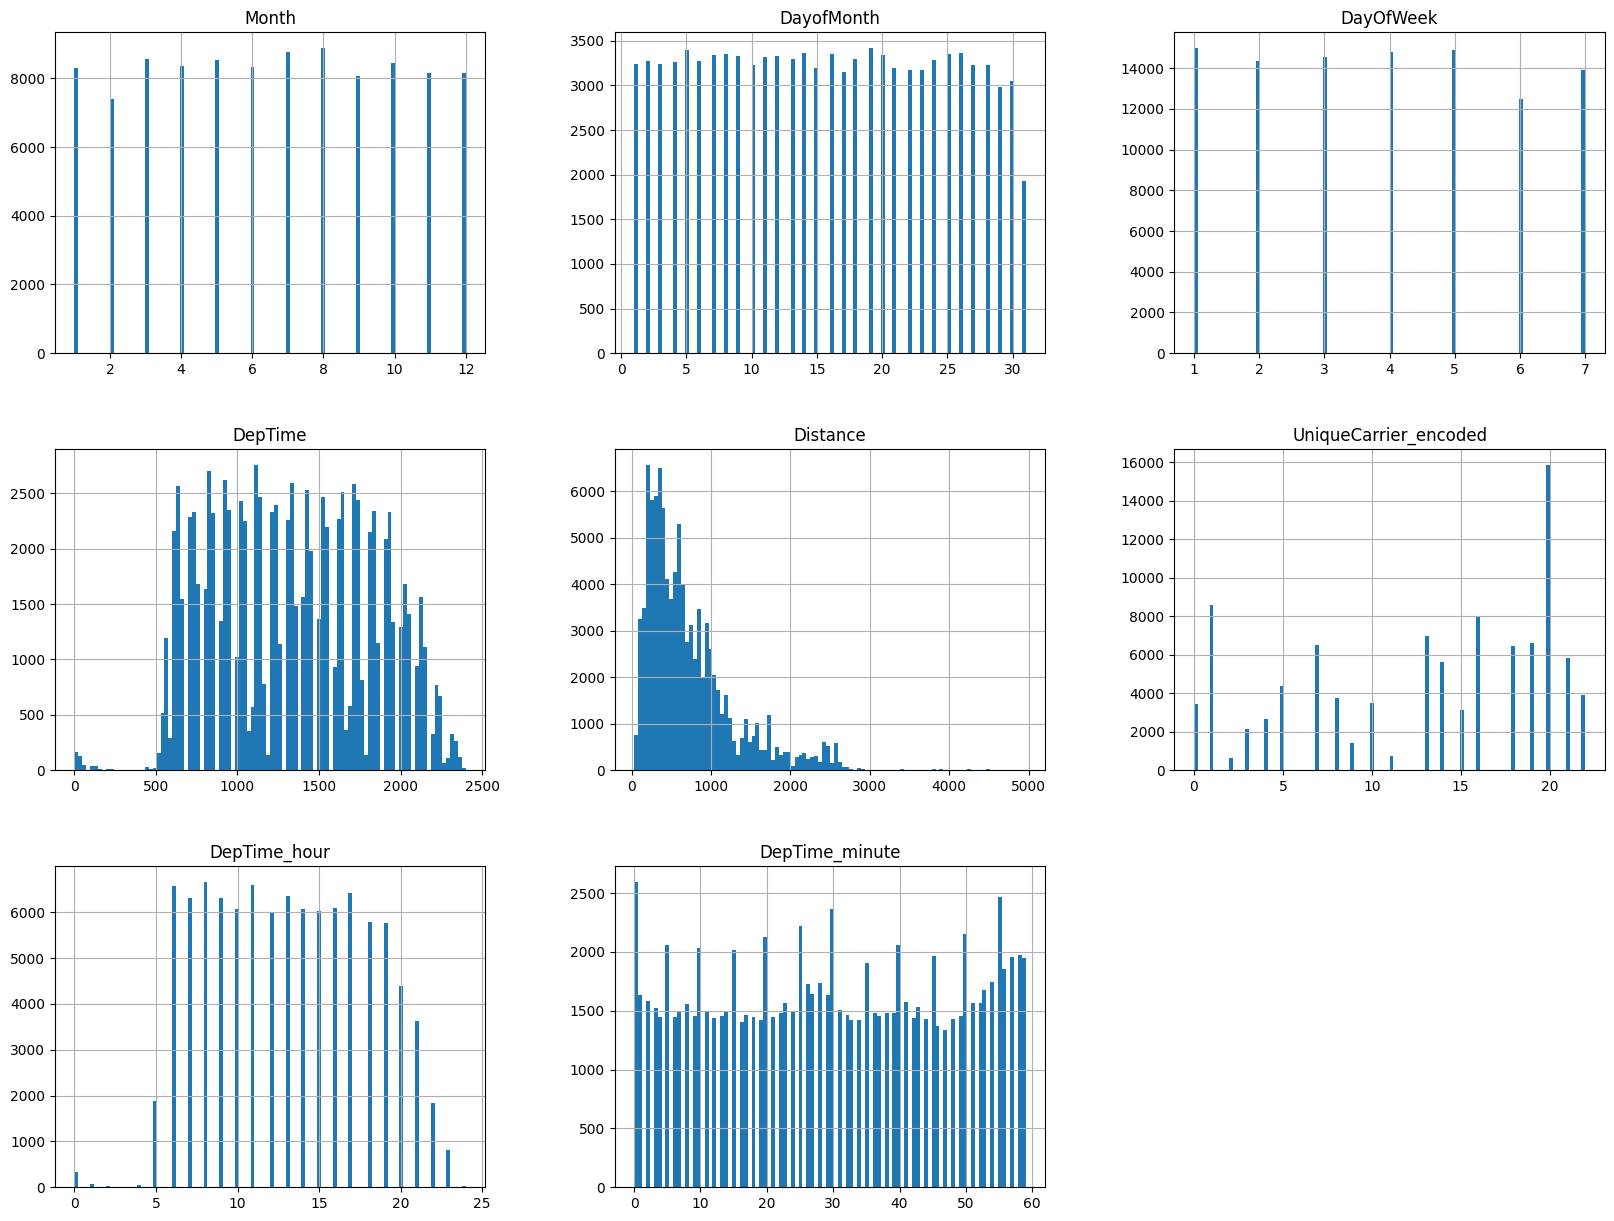

In [121]:
test.hist(bins=100, figsize=(20,15))
plt.grid()
plt.show()

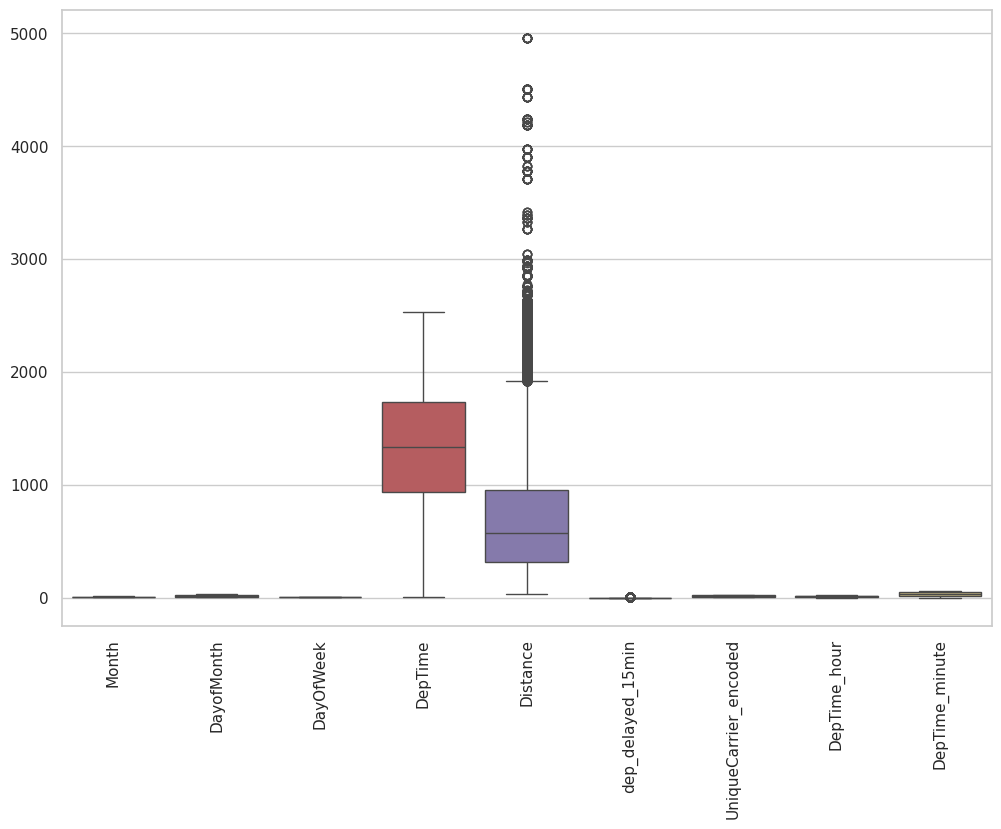

In [126]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.boxplot(data=train)
plt.xticks(rotation=90)
plt.show()

## Experiments

In [97]:
cols = ['dep_delayed_15min', 'UniqueCarrier', 'Origin', 'Dest']
X, X_test = prepare_df(train, test, cols)

In [30]:
y = train['dep_delayed_15min'].copy()
y

0        0
1        0
2        0
3        0
4        1
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: dep_delayed_15min, Length: 100000, dtype: object

### CatBoost

In [43]:
cat_features = ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'UniqueCarrier_encoded', 'DepTime_hour', 'DepTime_minute', 'Route']

#### Dimensional filter without Holdout

In [44]:
gb_model = CatBoostClassifier(eval_metric='AUC', cat_features=cat_features, random_state= 42)
gb_model.fit(X, y, cat_features=cat_features, use_best_model=True, verbose=True)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.07361
0:	total: 62.7ms	remaining: 1m 2s
1:	total: 140ms	remaining: 1m 9s
2:	total: 195ms	remaining: 1m 4s
3:	total: 250ms	remaining: 1m 2s
4:	total: 312ms	remaining: 1m 2s
5:	total: 333ms	remaining: 55.1s
6:	total: 381ms	remaining: 54.1s
7:	total: 456ms	remaining: 56.6s
8:	total: 542ms	remaining: 59.7s
9:	total: 584ms	remaining: 57.8s
10:	total: 636ms	remaining: 57.2s
11:	total: 692ms	remaining: 57s
12:	total: 753ms	remaining: 57.2s
13:	total: 791ms	remaining: 55.7s
14:	total: 816ms	remaining: 53.6s
15:	total: 895ms	remaining: 55.1s
16:	total: 968ms	remaining: 56s
17:	total: 1.04s	remaining: 56.6s
18:	total: 1.12s	remaining: 58.1s
19:	total: 1.2s	remaining: 58.6s
20:	total: 1.24s	remaining: 57.7s
21:	total: 1.31s	remaining: 58.4s
22:	total: 1.38s	remaining: 58.7s
23:	total: 1.46s	remaining: 59.4s
24:	total: 1.53s	remaining: 59.7s
25:	total: 1.63s	remaining: 1m 1s
26:	total: 1.72s	remaining: 1m 2s
27:	total: 1.81s	remaining: 1m 2s
28:	total: 1.85s	remaining: 1m 1s

In [45]:
gb_test_pred = gb_model.predict_proba(X_test)[:, 1]
pd.Series(gb_test_pred, name='dep_delayed_15min').to_csv('rjhxa_gsg.csv', index_label='id', header=True)

> RESULT: 0.73289

#### Dimensional filter with Holdout (CROOS VALIDATION 5 FOLDS)

In [47]:
y = y.astype(int)

In [48]:
cat_features = ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'UniqueCarrier_encoded', 'DepTime_hour', 'DepTime_minute', 'Route']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.3, random_state=42)

In [49]:
cb_model = CatBoostClassifier(eval_metric='AUC', cat_features=cat_features, early_stopping_rounds=40)
scores  = cross_val_score(cb_model, X_train, y_train, cv=5, scoring='roc_auc')
mean_roc_auc = scores.mean()
print(f'Mean ROC AUC Score (cross-validated): {mean_roc_auc}')


cb_model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=cat_features, use_best_model=True, verbose=True)
val_pred = cb_model.predict_proba(X_val)[:, 1]
val_roc_auc = roc_auc_score(y_val, val_pred)
print(f'ROC AUC Score (validation set): {val_roc_auc}')

Learning rate set to 0.057466
0:	total: 35.8ms	remaining: 35.8s
1:	total: 51.5ms	remaining: 25.7s
2:	total: 84.9ms	remaining: 28.2s
3:	total: 102ms	remaining: 25.3s
4:	total: 125ms	remaining: 24.8s
5:	total: 160ms	remaining: 26.6s
6:	total: 192ms	remaining: 27.2s
7:	total: 218ms	remaining: 27s
8:	total: 235ms	remaining: 25.9s
9:	total: 261ms	remaining: 25.9s
10:	total: 292ms	remaining: 26.2s
11:	total: 319ms	remaining: 26.3s
12:	total: 334ms	remaining: 25.4s
13:	total: 373ms	remaining: 26.3s
14:	total: 413ms	remaining: 27.1s
15:	total: 432ms	remaining: 26.6s
16:	total: 449ms	remaining: 26s
17:	total: 488ms	remaining: 26.6s
18:	total: 497ms	remaining: 25.6s
19:	total: 530ms	remaining: 26s
20:	total: 557ms	remaining: 26s
21:	total: 611ms	remaining: 27.1s
22:	total: 655ms	remaining: 27.8s
23:	total: 691ms	remaining: 28.1s
24:	total: 738ms	remaining: 28.8s
25:	total: 788ms	remaining: 29.5s
26:	total: 827ms	remaining: 29.8s
27:	total: 880ms	remaining: 30.6s
28:	total: 923ms	remaining: 30.9s

In [50]:
pred = cb_model.predict_proba(X_test)[:,1]
pd.Series(pred, name='dep_delayed_15min').to_csv('rjhxa_gsg2.csv', index_label='id', header=True)

> RESULT: 0.72632

#### All Dimensions with Holdout

In [109]:
cols = ['UniqueCarrier', 'dep_delayed_15min']
X_aux, X_aux_test = prepare_df(train, test, cols)

In [110]:
cat_features = ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Origin', 'Dest', 'Distance', 'UniqueCarrier_encoded', 'DepTime_hour', 'DepTime_minute', 'Route']

In [111]:
X_train, X_val, y_train, y_val = train_test_split(X_aux, y, test_size= 0.2, random_state=33)

In [112]:
cb_model = CatBoostClassifier(eval_metric='AUC', cat_features=cat_features, early_stopping_rounds=40)
cb_model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=cat_features, use_best_model=True, verbose=True)
val_pred = cb_model.predict_proba(X_val)[:, 1]
val_roc_auc = roc_auc_score(y_val, val_pred)
print(f'ROC AUC Score (validation set): {val_roc_auc}')

Learning rate set to 0.093535
0:	test: 0.6867129	best: 0.6867129 (0)	total: 129ms	remaining: 2m 9s
1:	test: 0.6946101	best: 0.6946101 (1)	total: 179ms	remaining: 1m 29s
2:	test: 0.7007843	best: 0.7007843 (2)	total: 256ms	remaining: 1m 25s
3:	test: 0.7006804	best: 0.7007843 (2)	total: 279ms	remaining: 1m 9s
4:	test: 0.7122714	best: 0.7122714 (4)	total: 374ms	remaining: 1m 14s
5:	test: 0.7152462	best: 0.7152462 (5)	total: 421ms	remaining: 1m 9s
6:	test: 0.7158684	best: 0.7158684 (6)	total: 443ms	remaining: 1m 2s
7:	test: 0.7159868	best: 0.7159868 (7)	total: 525ms	remaining: 1m 5s
8:	test: 0.7168891	best: 0.7168891 (8)	total: 641ms	remaining: 1m 10s
9:	test: 0.7197262	best: 0.7197262 (9)	total: 748ms	remaining: 1m 14s
10:	test: 0.7210801	best: 0.7210801 (10)	total: 848ms	remaining: 1m 16s
11:	test: 0.7209293	best: 0.7210801 (10)	total: 974ms	remaining: 1m 20s
12:	test: 0.7238719	best: 0.7238719 (12)	total: 1.07s	remaining: 1m 21s
13:	test: 0.7261353	best: 0.7261353 (13)	total: 1.19s	remai

In [113]:
pred = cb_model.predict_proba(X_aux_test)[:,1]
pd.Series(pred, name='dep_delayed_15min').to_csv('rjhxa_gsg5.csv', index_label='id', header=True)

> RESULT: 0.73635
> RESULT 2: 0.73867

#### All Dimensions without Holdout

In [92]:
cb_model = CatBoostClassifier(eval_metric='AUC', cat_features=cat_features, early_stopping_rounds=40)
cb_model.fit(X_aux, y, cat_features=cat_features, use_best_model=True, verbose=True)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.07361
0:	total: 76.5ms	remaining: 1m 16s
1:	total: 153ms	remaining: 1m 16s
2:	total: 253ms	remaining: 1m 24s
3:	total: 347ms	remaining: 1m 26s
4:	total: 392ms	remaining: 1m 18s
5:	total: 510ms	remaining: 1m 24s
6:	total: 552ms	remaining: 1m 18s
7:	total: 612ms	remaining: 1m 15s
8:	total: 665ms	remaining: 1m 13s
9:	total: 789ms	remaining: 1m 18s
10:	total: 881ms	remaining: 1m 19s
11:	total: 952ms	remaining: 1m 18s
12:	total: 1.03s	remaining: 1m 18s
13:	total: 1.09s	remaining: 1m 16s
14:	total: 1.15s	remaining: 1m 15s
15:	total: 1.26s	remaining: 1m 17s
16:	total: 1.35s	remaining: 1m 18s
17:	total: 1.45s	remaining: 1m 19s
18:	total: 1.56s	remaining: 1m 20s
19:	total: 1.62s	remaining: 1m 19s
20:	total: 1.74s	remaining: 1m 20s
21:	total: 1.85s	remaining: 1m 22s
22:	total: 1.97s	remaining: 1m 23s
23:	total: 2.05s	remaining: 1m 23s
24:	total: 2.17s	remaining: 1m 24s
25:	total: 2.25s	remaining: 1m 24s
26:	total: 2.36s	remaining: 1m 25s
27:	total: 2.47s	remaining: 1m 25s


In [93]:
pred = cb_model.predict_proba(X_aux_test)[:,1]
pd.Series(pred, name='dep_delayed_15min').to_csv('rjhxa_gsg4.csv', index_label='id', header=True)

> RESULT: 0.74376

#### TESTE

In [148]:
cols = ['UniqueCarrier', 'dep_delayed_15min']
X, X_test = prepare_df(train, test, cols)

In [152]:
cat_features = [
    'Month', 'DayofMonth', 'DayOfWeek', 'DepTime',
    'Origin', 'Dest', 'Distance', 'UniqueCarrier_encoded', 
    'DepTime_hour', 'DepTime_minute', 'Route', 'Time_period'
]

In [153]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.2, random_state=33)

In [154]:
cb_model = CatBoostClassifier(eval_metric='AUC', cat_features=cat_features, early_stopping_rounds=40)
cb_model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=cat_features, use_best_model=True, verbose=True)
val_pred = cb_model.predict_proba(X_val)[:, 1]
val_roc_auc = roc_auc_score(y_val, val_pred)
print(f'ROC AUC Score (validation set): {val_roc_auc}')

Learning rate set to 0.093535
0:	test: 0.6791012	best: 0.6791012 (0)	total: 100ms	remaining: 1m 40s
1:	test: 0.6954231	best: 0.6954231 (1)	total: 215ms	remaining: 1m 47s
2:	test: 0.6992156	best: 0.6992156 (2)	total: 306ms	remaining: 1m 41s
3:	test: 0.7020525	best: 0.7020525 (3)	total: 398ms	remaining: 1m 39s
4:	test: 0.7020521	best: 0.7020525 (3)	total: 474ms	remaining: 1m 34s
5:	test: 0.7068617	best: 0.7068617 (5)	total: 523ms	remaining: 1m 26s
6:	test: 0.7061492	best: 0.7068617 (5)	total: 546ms	remaining: 1m 17s
7:	test: 0.7076729	best: 0.7076729 (7)	total: 618ms	remaining: 1m 16s
8:	test: 0.7096602	best: 0.7096602 (8)	total: 751ms	remaining: 1m 22s
9:	test: 0.7121339	best: 0.7121339 (9)	total: 909ms	remaining: 1m 30s
10:	test: 0.7147561	best: 0.7147561 (10)	total: 1.01s	remaining: 1m 30s
11:	test: 0.7158576	best: 0.7158576 (11)	total: 1.12s	remaining: 1m 32s
12:	test: 0.7175416	best: 0.7175416 (12)	total: 1.21s	remaining: 1m 31s
13:	test: 0.7180737	best: 0.7180737 (13)	total: 1.32s	

In [155]:
pred = cb_model.predict_proba(X_test)[:,1]
pd.Series(pred, name='dep_delayed_15min').to_csv('rjhxa_gsg6.csv', index_label='id', header=True)

> RESULT: 0.73997

### TESTE

In [175]:
cols = ['UniqueCarrier', 'dep_delayed_15min']
X, X_test = prepare_df(train, test, cols)

In [176]:
X.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Origin', 'Dest',
       'Distance', 'UniqueCarrier_encoded', 'DepTime_hour', 'DepTime_minute',
       'Route', 'Time_period', 'Route_Hour', 'Carrier_Origin', 'Carrier_Dest',
       'Carrier_DepHour'],
      dtype='object')

In [177]:
cat_features = ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Origin', 'Dest',
       'Distance', 'UniqueCarrier_encoded', 'DepTime_hour', 'DepTime_minute',
       'Route', 'Time_period', 'Route_Hour', 'Carrier_Origin', 'Carrier_Dest',
       'Carrier_DepHour'
]

In [178]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.2, random_state=33)

In [179]:
cb_model = CatBoostClassifier(eval_metric='AUC', cat_features=cat_features, early_stopping_rounds=40)
cb_model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=cat_features, use_best_model=True, verbose=True)
val_pred = cb_model.predict_proba(X_val)[:, 1]
val_roc_auc = roc_auc_score(y_val, val_pred)
print(f'ROC AUC Score (validation set): {val_roc_auc}')

Learning rate set to 0.093535
0:	test: 0.7011601	best: 0.7011601 (0)	total: 141ms	remaining: 2m 20s
1:	test: 0.7036151	best: 0.7036151 (1)	total: 214ms	remaining: 1m 46s
2:	test: 0.7064826	best: 0.7064826 (2)	total: 336ms	remaining: 1m 51s
3:	test: 0.7093582	best: 0.7093582 (3)	total: 430ms	remaining: 1m 47s
4:	test: 0.7128915	best: 0.7128915 (4)	total: 525ms	remaining: 1m 44s
5:	test: 0.7138755	best: 0.7138755 (5)	total: 600ms	remaining: 1m 39s
6:	test: 0.7187295	best: 0.7187295 (6)	total: 763ms	remaining: 1m 48s
7:	test: 0.7191202	best: 0.7191202 (7)	total: 903ms	remaining: 1m 51s
8:	test: 0.7198334	best: 0.7198334 (8)	total: 1.04s	remaining: 1m 54s
9:	test: 0.7221890	best: 0.7221890 (9)	total: 1.16s	remaining: 1m 54s
10:	test: 0.7230585	best: 0.7230585 (10)	total: 1.28s	remaining: 1m 55s
11:	test: 0.7230585	best: 0.7230585 (10)	total: 1.3s	remaining: 1m 47s
12:	test: 0.7245266	best: 0.7245266 (12)	total: 1.43s	remaining: 1m 48s
13:	test: 0.7305707	best: 0.7305707 (13)	total: 1.6s	re

In [180]:
pred = cb_model.predict_proba(X_test)[:,1]
pd.Series(pred, name='dep_delayed_15min').to_csv('rjhxa_gsg8.csv', index_label='id', header=True)

> Result: 0.74001

In [181]:
cb_model = CatBoostClassifier(eval_metric='AUC', cat_features=cat_features, early_stopping_rounds=40)
cb_model.fit(X, y, cat_features=cat_features, use_best_model=True, verbose=True)
pred = cb_model.predict_proba(X_test)[:,1]
pd.Series(pred, name='dep_delayed_15min').to_csv('rjhxa_gsg9.csv', index_label='id', header=True)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.07361
0:	total: 113ms	remaining: 1m 53s
1:	total: 264ms	remaining: 2m 11s
2:	total: 381ms	remaining: 2m 6s
3:	total: 493ms	remaining: 2m 2s
4:	total: 552ms	remaining: 1m 49s
5:	total: 592ms	remaining: 1m 38s
6:	total: 672ms	remaining: 1m 35s
7:	total: 705ms	remaining: 1m 27s
8:	total: 753ms	remaining: 1m 22s
9:	total: 848ms	remaining: 1m 23s
10:	total: 993ms	remaining: 1m 29s
11:	total: 1.19s	remaining: 1m 38s
12:	total: 1.34s	remaining: 1m 41s
13:	total: 1.5s	remaining: 1m 45s
14:	total: 1.59s	remaining: 1m 44s
15:	total: 1.65s	remaining: 1m 41s
16:	total: 1.79s	remaining: 1m 43s
17:	total: 1.89s	remaining: 1m 42s
18:	total: 2.03s	remaining: 1m 45s
19:	total: 2.17s	remaining: 1m 46s
20:	total: 2.34s	remaining: 1m 48s
21:	total: 2.49s	remaining: 1m 50s
22:	total: 2.65s	remaining: 1m 52s
23:	total: 2.82s	remaining: 1m 54s
24:	total: 2.97s	remaining: 1m 55s
25:	total: 3.09s	remaining: 1m 55s
26:	total: 3.15s	remaining: 1m 53s
27:	total: 3.27s	remaining: 1m 53s
28:	

> Result: 0.74433